# Preprocessing in Remote Sensing: Resample, Pansharpening

---

This section outlines two fundamental preprocessing operations required to ensure the spatial resolution of geospatial raster datasets:

- **Resampling** is the process of changing the spatial resolution of a raster image by interpolating pixel values to fit a new grid. Nonetheless, resampling with traditionnal method (nearest neighbor, cubic, biliniear) will cause information loss.

- **Pan-sharpening** is a technique that merges a high-resolution panchromatic image with lower-resolution multispectral images to create a multispectral image with higher spatial resolution. However, this methods cause some spectral distortion.

This two process are fast and efficient but they have a loss in quality. If we want to improve the spectral and spatial quality, we can use the new process of super-resolution like Dsen2. We will see this part in another chapter.

---

## Import

In [1]:
from osgeo import gdal,gdalconst,osr
gdal.UseExceptions()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

---

## Resample

In the file reprojection_alignment_cliping, we create a tif call T59GPM_square.tif. We will use this file to do an example of resampling. This tif has a 20 m of resolution, you can verify with gdal.info. Since, the files contains a reflectance data, the most appropriate methods is bilinear. With gdal, we only have to call gdal.warp if we want a resample.


In [9]:
ds=gdal.Warp(
    "T59GPM_square_10m.tif",            # Output file
    "T59GPM_square.tif",                # Source file
    xRes=10, yRes=10,                   # New resolution (10m instead of 20m)
    resampleAlg='bilinear'              # See gdal.warp for others methods
)
ds=None

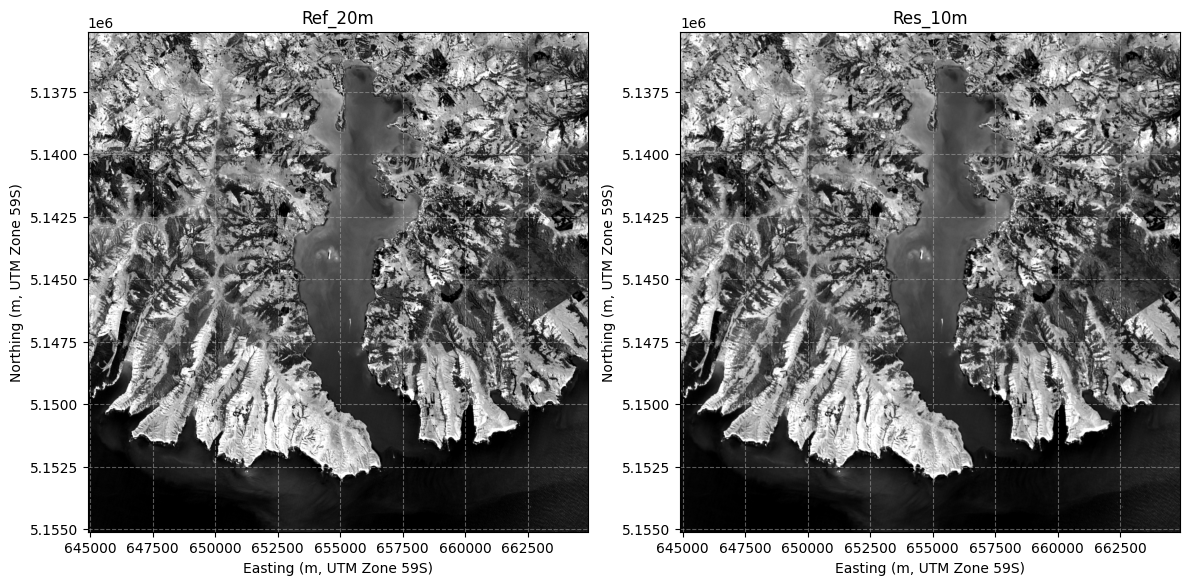

In [10]:
def read_and_stretch(path, vmin=None, vmax=None, pmin=2, pmax=98):
    """
    Reads a raster file, computes its spatial extent, and applies contrast stretching 
    based on given or percentile-based min and max values.

    Returns the stretched array (scaled 0-1), extent tuple, and used min/max values.
    """
    ds = gdal.Open(path)
    band = ds.GetRasterBand(1)
    array = band.ReadAsArray()
    gt = ds.GetGeoTransform()
    cols, rows = ds.RasterXSize, ds.RasterYSize
    ds = None   
    extent = ( gt[0], gt[0] + cols * gt[1], gt[3],gt[3] + rows * gt[5])     # xmin, xmax, ymin, ymax
    if vmin is None or vmax is None:
        vmin, vmax = np.percentile(array, (pmin, pmax))
    stretched = np.clip((array - vmin) / (vmax - vmin), 0, 1)
    return stretched, extent, vmin, vmax

# We want the same stretch for all raster. So all the raster have ref_stretch
ref_path = "T59GPM_square.tif"
size_path = "T59GPM_square_10m.tif"

ref_img, ref_extent, vmin, vmax = read_and_stretch(ref_path)
size_img, size_extent,_,_ = read_and_stretch(size_path, vmin, vmax)

# Display
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
titles = ["Ref_20m", "Res_10m"]
images = [(ref_img, ref_extent), (size_img, size_extent)]

for ax, (img, extent), title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray', extent=extent)
    ax.set_title(title)
    ax.set_xlabel("Easting (m, UTM Zone 59S)")
    ax.set_ylabel("Northing (m, UTM Zone 59S)")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


---

## Pansharpening

Now, we are going to see how to do pansharpening on Sentinel-2. Nonetheless, Sentinel-2 data doesn't have a panchromatic band. So we will create a synthetic PAN with the 4 four 10 meter bands (B2,B3,B4,B8) and average the whole. This method is done in *Loncan et al. (2015) Hyperspectral pansharpening:A review* and you can find different method for the pansharpening. In this code, we will use the PCA because this is simple and efficient. For this exemple, we will only pansharpening the 20m_BAND_5.

In [ ]:
def read_band(path):
    ds = gdal.Open(path)
    band = ds.GetRasterBand(1).ReadAsArray()
    gt = ds.GetGeoTransform()
    proj = ds.GetProjection()
    return band, gt, proj

def write_geotiff(path, array, geotransform, projection):
    driver = gdal.GetDriverByName("GTiff")
    rows, cols = array.shape
    out_ds = driver.Create(path, cols, rows, 1, gdal.GDT_UInt16)
    out_ds.SetGeoTransform(geotransform)
    out_ds.SetProjection(projection)
    out_ds.GetRasterBand(1).WriteArray(array)
    out_ds.FlushCache()
    out_ds = None


# PAN Band creation
b2, gt, proj = read_band("data_copernicus_unzip/S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431.SAFE/GRANULE/L2A_T59GPM_A019331_20190305T222532/IMG_DATA/R10m/T59GPM_20190305T222531_B02_10m.jp2")
b3, _, _ = read_band("data_copernicus_unzip/S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431.SAFE/GRANULE/L2A_T59GPM_A019331_20190305T222532/IMG_DATA/R10m/T59GPM_20190305T222531_B03_10m.jp2")
b4, _, _ = read_band("data_copernicus_unzip/S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431.SAFE/GRANULE/L2A_T59GPM_A019331_20190305T222532/IMG_DATA/R10m/T59GPM_20190305T222531_B04_10m.jp2")
b8, _, _ = read_band("data_copernicus_unzip/S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431.SAFE/GRANULE/L2A_T59GPM_A019331_20190305T222532/IMG_DATA/R10m/T59GPM_20190305T222531_B08_10m.jp2")
pan = ((b2.astype(np.float32) + b3 + b4 + b8) / 4).astype(np.float32)
write_geotiff("PAN_10m.tif", pan, gt, proj) #optional

# 20m_band_5 resample at 10m with bilinear
ds=gdal.Warp(
    "B5_10m.tif",
    "data_copernicus_unzip/S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431.SAFE/GRANULE/L2A_T59GPM_A019331_20190305T222532/IMG_DATA/R20m/T59GPM_20190305T222531_B05_20m.jp2",
    xRes=10, yRes=10,
    resampleAlg='bilinear'
)
ds=None

# Stack [PAN, B5_10m_bilinear]
b5_interp, _, _ = read_band("B5_10m.tif")
stack = np.stack([pan, b5_interp], axis=-1)
rows, cols, bands = stack.shape
flat = stack.reshape(-1, 2) # we reshape for the PCA => we obtain : each line is a pixel with two values (PAN, B5)

# PCA
pca = PCA()
transformed = pca.fit_transform(flat) # we get an array with the main component 1 and 2 => each line is (PC1,PC2)
transformed[:, 0] = pan.flatten() # we replace the PCA1 by the pan pixel values => each line is (PAN,PC2)

reconstructed = pca.inverse_transform(transformed) # PCA is a linear transformation so we can reverse it => each line (a different PAN, B5 improved)
b5_sharpened = reconstructed[:, 1].reshape(rows, cols).astype(np.uint16) # we reshape only the B5 cols to save it later

write_geotiff("B5_pansharpened.tif", b5_sharpened, gt, proj)


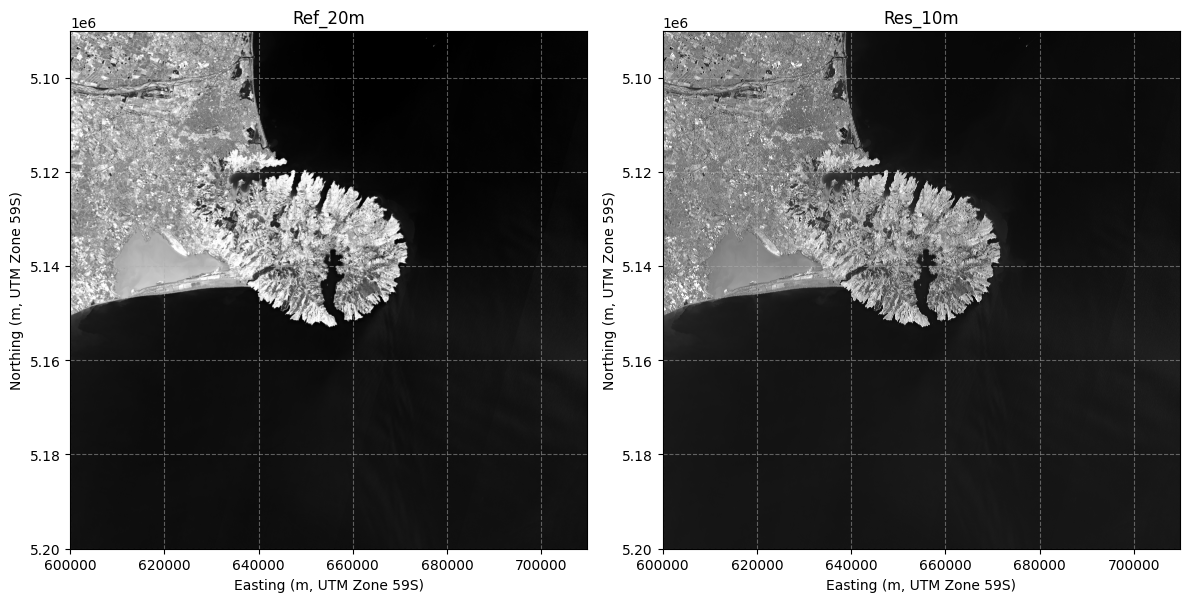

In [2]:
def read_and_stretch(path, vmin=None, vmax=None, pmin=2, pmax=98):
    """
    Reads a raster file, computes its spatial extent, and applies contrast stretching 
    based on given or percentile-based min and max values.

    Returns the stretched array (scaled 0-1), extent tuple, and used min/max values.
    """
    ds = gdal.Open(path)
    band = ds.GetRasterBand(1)
    array = band.ReadAsArray()
    gt = ds.GetGeoTransform()
    cols, rows = ds.RasterXSize, ds.RasterYSize
    ds = None   
    extent = ( gt[0], gt[0] + cols * gt[1], gt[3],gt[3] + rows * gt[5])     # xmin, xmax, ymin, ymax
    if vmin is None or vmax is None:
        vmin, vmax = np.percentile(array, (pmin, pmax))
    stretched = np.clip((array - vmin) / (vmax - vmin), 0, 1)
    return stretched, extent, vmin, vmax

# We want the same stretch for all raster. So all the raster have ref_stretch
ref_path = "data_copernicus_unzip/S2A_MSIL2A_20190305T222531_N0500_R029_T59GPM_20221119T040431.SAFE/GRANULE/L2A_T59GPM_A019331_20190305T222532/IMG_DATA/R20m/T59GPM_20190305T222531_B05_20m.jp2"
size_path = "B5_pansharpened.tif"

ref_img, ref_extent, vmin, vmax = read_and_stretch(ref_path)
size_img, size_extent,_,_ = read_and_stretch(size_path, vmin, vmax)

# Display
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
titles = ["Ref_20m", "Res_10m"]
images = [(ref_img, ref_extent), (size_img, size_extent)]

for ax, (img, extent), title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray', extent=extent)
    ax.set_title(title)
    ax.set_xlabel("Easting (m, UTM Zone 59S)")
    ax.set_ylabel("Northing (m, UTM Zone 59S)")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
